# Emails_multiclassification

## Import des packages

In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import re
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import mailparser
from sklearn.metrics import classification_report # for model evaluation metrics
sys.path.insert(0, '/home/felix/code/mlerend/thetidinbox_1004/thetidinbox_1004')

## Import of labeled emails

In [70]:
emails_df = pd.DataFrame({"message" : [],
                         "category" : []})
for i in range(1,9):
    path_data = f'../../raw_data/enron/emails/txt_files_categories/all_txt_files{i}.txt'
    with open(path_data) as f:
        contents = f.read()
        emails_cat = ["Message-ID: " + email for email in contents.split("Message-ID: ") if email]
        emails_df = pd.concat([emails_df, pd.DataFrame({"message" : emails_cat,
                         "category" : int(i)})]).reset_index(drop=True)

In [71]:
emails_df_gh = pd.read_csv('https://raw.githubusercontent.com/brindasachi97/Enron-Email-Classification/master/combinedDS.csv')


## Import of sample of non-labeled emails

In [72]:
emails_sample_df = pd.read_csv("../../raw_data/enron/emails.csv", nrows = 20000)

## Parsing

In [73]:
def extract_date(email):
    mail = mailparser.parse_from_string(email)
    date = mail.date
    return date

def extract_sender(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.from_) > 0:
        sender = mail.from_[0][1]
    else:
        sender = mail.from_
    return sender

def extract_recipients(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.to) > 0:
        to = ",".join([rec[1] for rec in mail.to])
    else:
        to = mail.to
    return to

def extract_header(email):
    mail = mailparser.parse_from_string(email)
    header = mail.subject
    return header

def extract_body(email, failure="", *exceptions):
    try:
        mail = mailparser.parse_from_string(email)
        body = mail.body
    except exceptions or Exception:
        return failure
    return body

### Parsing labeled emails

In [74]:
emails_df_parsed = pd.DataFrame()
emails_df_parsed["ID"] = emails_df["message"].apply(lambda x: re.search(r'\d+',x)[0])
# emails_df_parsed["date"] = emails_df["message"].apply(extract_date)
# emails_df_parsed["from"] = emails_df["message"].apply(extract_sender)
# emails_df_parsed["to"] = emails_df["message"].apply(extract_recipients)
# emails_df_parsed["header"] = emails_df["message"].apply(extract_header)
emails_df_parsed["body"] = emails_df["message"].apply(extract_body)
emails_df_parsed["category"] = emails_df["category"]
emails_df_parsed.head()

Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled


,ID,body,category
0,197504,---------------------- Forwarded by Steven J K...,1.0
1,11991339,In anticipation of potential litigation involv...,1.0
2,7106753,Julia and Steve--here are some questions I've ...,1.0
3,21267718,Julia and Steve--here are some questions I've ...,1.0
4,20866019,In anticipation of potential litigation involv...,1.0


### Parsing non-labeled emails

In [75]:
emails_sample_df_parsed = pd.DataFrame()
emails_sample_df_parsed["ID"] = emails_sample_df["message"].apply(lambda x: re.search(r'\d+',x)[0])
# emails_sample_df_parsed["date"] = emails_sample_df["message"].apply(extract_date)
# emails_sample_df_parsed["from"] = emails_sample_df["message"].apply(extract_sender)
# emails_sample_df_parsed["to"] = emails_sample_df["message"].apply(extract_recipients)
# emails_sample_df_parsed["header"] = emails_sample_df["message"].apply(extract_header)
emails_sample_df_parsed["body"] = emails_sample_df["message"].apply(extract_body)
emails_sample_df_parsed["category"] = -1
emails_sample_df_parsed.head()

,ID,body,category
0,18782981,Here is our forecast\n\n,-1
1,15464986,Traveling to have a business meeting takes the...,-1
2,24216240,test successful. way to go!!!,-1
3,13505866,"Randy,\n\n Can you send me a schedule of the s...",-1
4,30922949,Let's shoot for Tuesday at 11:45.,-1


## Concatenating the labeled and non-labeled emails

### Removing potential labeled emails in the non-labeled emails sample

In [76]:
ID_labeled = emails_df_parsed.ID.unique()
ID_non_labeled = emails_sample_df_parsed.ID.unique()
ID_to_delete = []
for id_email in ID_labeled:
    if id_email in ID_non_labeled:
        ID_to_delete.append(id_email)
emails_sample_df_parsed = emails_sample_df_parsed[~emails_sample_df_parsed["ID"].isin(ID_to_delete)]
emails_sample_df_parsed.shape

(19981, 3)

### Concatenating

In [77]:
emails_df_all = pd.concat([emails_df_parsed,emails_sample_df_parsed], axis=0).reset_index(drop=True)
emails_df_all.shape

(21697, 3)

## Data exploration

In [78]:
num_email_per_cat = emails_df_all[emails_df_all["category"]!=-1]["category"].value_counts().sort_index()
weight_email_per_cat = emails_df_all[emails_df_all["category"]!=-1]["category"].value_counts(normalize=True).sort_index()
num_mail_df = pd.DataFrame({"number of emails" : num_email_per_cat.values,
             "% of total" : round(weight_email_per_cat,2)}, index = num_email_per_cat.index)
num_mail_df.loc["Total"] = num_mail_df.sum()
num_mail_df

,number of emails,% of total
1.0,839.0,0.49
2.0,38.0,0.02
3.0,102.0,0.06
4.0,480.0,0.28
5.0,74.0,0.04
6.0,144.0,0.08
7.0,21.0,0.01
8.0,18.0,0.01
Total,1716.0,0.99


In [79]:
avg_length = int(emails_df_all["body"].apply(lambda x : len(x)).mean())
print(f"Le nombre moyen de mots par email est de {avg_length}")

Le nombre moyen de mots par email est de 2264


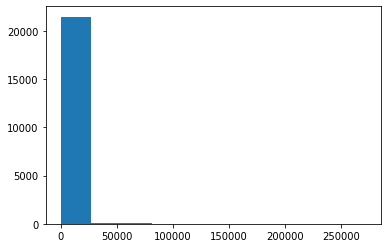

In [80]:
plt.hist(emails_df_all["body"].apply(lambda x : len(x)));

## Data cleaning

In [81]:
def clean_email(email):

    # Remove mentions
    email = re.sub(r'@\w+', '', email)
    # Remove urls
    email = re.sub(r'http\S+', ' ', email)
    # Remove digits
    email = re.sub("\d+", " ", email)
    # Remove backline character
    email = email.replace('\n', ' ')
    # Remove forwarded emails
#     email = re.sub("Forwarded by.*$",' ', email)
#     email = re.sub("Original Message.*$",' ', email)
    
    # Remove digits between brackets
    email = re.sub(r'<.*>', '', email)
    # Remove punctuations
    email = email.translate(str.maketrans(" ", " ", punctuation))
    email = email.lower()
    # Remove some keyword
    elements_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
     'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
     'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --', '-', '/', '\n', 'Re:', 'FW:']
    for element in elements_to_drop:
        email = email.replace(element, '')

    return email

In [82]:
# emails_df_m_cleaned = emails_df_m_cleaned.loc[emails_df_m[name_col_email].notna()]
# emails_df_m_cleaned[name_col_email] = emails_df_m_cleaned[name_col_email].apply(clean_email)

emails_df_all_cleaned = emails_df_all.loc[emails_df_all["body"].notna()]
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(clean_email)

## Stopwords removal

Removing English stopwords

In [83]:
def stopword_removal(email):

    stop_words = set(stopwords.words('english')) 

    email = email.split()
    filtered_sentence = ""

    for w in email: 
        if w not in stop_words: 
            filtered_sentence = filtered_sentence + w +" "

    return filtered_sentence

In [84]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(stopword_removal)

## Tokenizing

Transforming string into a list of words

In [85]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(word_tokenize)

## Lemmatizing

Replacing each word by its root (ex: 'Working' ==> 'Work')

In [86]:
def lemmatizing(email):
    
    # 1 - Lemmating the verbs
    verb_lemmatized = [                  
    WordNetLemmatizer().lemmatize(word, pos = "v") # v --> verbs
    for word in email   
    ]

    # 2 - Lemmatizing the nouns
    noun_lemmatized = [                 
    WordNetLemmatizer().lemmatize(word, pos = "n") # n --> nouns
    for word in verb_lemmatized
    ]
    
    return noun_lemmatized

In [87]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(lemmatizing)

Removing empty message contents after preprocessing :

In [88]:
emails_df_all_cleaned = emails_df_all_cleaned[emails_df_all_cleaned["body"].map(lambda d: len(d)) > 0]

Converting list messages into string

In [89]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(lambda x: " ".join(x))

## Example

In [90]:
random_email_num = random.randint(0,len(emails_df_all_cleaned))
random_email_num

6114

### Before cleaning

In [91]:
emails_df_all.loc[random_email_num,"body"]

'Thanks for taking me in last night.  Sorry about being drunk and stinky.  \nMy cab, that we called at 6:10, showed up at 7:02.  I was so pissed.  '

### After cleaning

In [92]:
emails_df_all_cleaned.loc[random_email_num,"body"]

'thank take last night sorry drink stinky cab call show piss'

## Export csv

In [93]:
emails_df_all_cleaned.to_csv("emails_df_cleaned.csv")

## Initial model

### Evaluating a model based on the 1700 emails labelled

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV


# oversample = SMOTE()



# Considering only labeled emails
emails_df_all_cleaned_train = emails_df_all_cleaned[emails_df_all_cleaned["category"]!=-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned_train["body"], emails_df_all_cleaned_train["category"], test_size=0.2)

# Vectorizer
vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.7)

X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)


# X_train_counts, y_train = oversample.fit_resample(X_train_counts, y_train)

# Model
clf = SVC(probability=True)
clf.fit(X_train_counts, y_train)
y_pred = clf.predict(X_test_counts)

recall = recall_score(y_test, y_pred, average=None)
# recall_df = pd.DataFrame({"recall_score": recall.round(3)}, index=range(1,9))
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, clf.predict(X_test_counts)))
# print("Accuracy:", accuracy)

              precision    recall  f1-score   support

         1.0       0.66      0.87      0.75       175
         2.0       0.00      0.00      0.00        11
         3.0       0.00      0.00      0.00        17
         4.0       0.64      0.73      0.68        85
         5.0       1.00      0.09      0.17        11
         6.0       0.58      0.21      0.30        34
         7.0       0.00      0.00      0.00         4
         8.0       0.00      0.00      0.00         4

    accuracy                           0.65       341
   macro avg       0.36      0.24      0.24       341
weighted avg       0.59      0.65      0.59       341



/home/felix/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felix/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felix/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [111]:
emails_unlabeled = emails_df_all_cleaned[emails_df_all_cleaned["category"]==-1]["body"]
emails_unlabeled_ID = list(emails_df_all_cleaned[emails_df_all_cleaned["category"]==-1]["ID"])
emails_unlabeled_vec = vectorizer.transform(emails_unlabeled)


y_pred_proba = clf.predict_proba(emails_unlabeled_vec)
y_pred = clf.predict(emails_unlabeled_vec)

name_col_cat = ["cat_" + str(i) for i in range(1,9)]
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns = name_col_cat).reset_index(drop=True)
X_y_pred = pd.DataFrame({"ID":emails_unlabeled_ID,
            "body_clean" : emails_unlabeled,
            "category_pred" : y_pred}).reset_index(drop=True)
pred_df = pd.concat([X_y_pred, y_pred_proba_df], axis=1)

threshold = 0.8
pred_df["proba_cat"] = pred_df[name_col_cat].max(axis=1)
pred_df["keep_cat_pred"] = pred_df["proba_cat"].apply(lambda x: True if x> threshold else False)
new_emails_labeled = pred_df[(pred_df["category_pred"].isin([1,4,5,6])) & (pred_df["keep_cat_pred"])][["ID","body_clean"]]
new_emails_labeled_raw = pd.DataFrame(emails_df_all.loc[emails_df_all["ID"].isin(new_emails_labeled["ID"]),["ID","body"]]).reset_index(drop=True)
new_emails_labeled_raw.head()


,ID,body
0,18782981,Here is our forecast\n\n
1,17189699,any morning between 10 and 11:30
2,1115198,"Paula,\n\n 35 million is fine\n\nPhillip"
3,10523086,---------------------- Forwarded by Phillip K ...
4,4449575,---------------------- Forwarded by Phillip K ...


In [112]:
new_emails_labeled_raw.to_csv("new_emails_labeled.csv")

In [38]:
# plt.hist(pred_df["proba_cat"]);

## Labelling emails based on initial model

### Labelling

In [ ]:
# Train-test split on the whole dataset, with labeled and non labeled emails
X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned["body"], 
                                                    emails_df_all_cleaned["category"], 
                                                    test_size=0.2)

# Vectorizer
vectorizer = TfidfVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# X_train_counts, y_train = oversample.fit_resample(X_train_counts, y_train)


# Model
clf = SVC(probability=True)

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=clf, # An estimator object implementing fit and predict_proba.
                                             threshold=0.8, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=True # default=False, Verbosity prints some information after each iteration
                                            )
# Fit the model
clf_ST = self_training_model.fit(X_train_counts, y_train)

In [ ]:
########## Step 3 - Model Evaluation ########## 
print('')
print('---------- Self Training Model - Summary ----------')
print('Base Estimator: ', clf_ST.base_estimator_)
print('Classes: ', clf_ST.classes_)
print('Transduction Labels: ', clf_ST.transduction_)
#print('Iteration When Sample Was Labeled: ', clf_ST.labeled_iter_)
print('Number of Features: ', clf_ST.n_features_in_)
# print('Feature Names: ', clf_ST.feature_names_in_)

print('Number of Iterations: ', clf_ST.n_iter_)
print('Termination Condition: ', clf_ST.termination_condition_)
print('')

print('---------- Self Training Model - Evaluation on Test Data ----------')
accuracy_score_ST = clf_ST.score(X_test_counts, y_test)
print('Accuracy Score: ', accuracy_score_ST)
# Look at classification report to evaluate the model
print(classification_report(y_test, clf_ST.predict(X_test_counts)))

## Using BERT

In [58]:
from transformers import AutoTokenizer, BertTokenizer,TFBertForSequenceClassification
import tensorflow as tf

In [59]:
# Import tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Original sentence
random_email_num = random.randint(0,len(emails_df_all_cleaned))
random_email = emails_df_all_cleaned.loc[random_email_num,"body"] 
print("Original email: ", random_email)

# Sentence in tokens
print("Tokenized: ",tokenizer.tokenize(random_email))

# Sentence in token ids
print("Token IDs :", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(random_email)))

Original email:  please respond kevinscott steve draft contact list promise still typo clean get send draft morning ready circulation list make people know trust large exclude sit pubic official case give organization several useful contact similar knowledge list one person give call convenience discus great detail kevin kevin scott key contact draftdoc
Tokenized:  ['please', 'respond', 'kevin', '##sco', '##tt', 'steve', 'draft', 'contact', 'list', 'promise', 'still', 'ty', '##po', 'clean', 'get', 'send', 'draft', 'morning', 'ready', 'circulation', 'list', 'make', 'people', 'know', 'trust', 'large', 'exclude', 'sit', 'pub', '##ic', 'official', 'case', 'give', 'organization', 'several', 'useful', 'contact', 'similar', 'knowledge', 'list', 'one', 'person', 'give', 'call', 'convenience', 'discus', 'great', 'detail', 'kevin', 'kevin', 'scott', 'key', 'contact', 'draft', '##do', '##c']
Token IDs : [3531, 6869, 4901, 9363, 4779, 3889, 4433, 3967, 2862, 4872, 2145, 5939, 6873, 4550, 2131, 460

In [74]:
len(emails_df_all_cleaned_train["category"].value_counts())

8

In [79]:
# Considering only labeled emails
emails_df_all_cleaned_train = emails_df_all_cleaned[emails_df_all_cleaned["category"]!=-1]

y = tf.keras.utils.to_categorical(emails_df_all_cleaned_train["category"].values)

X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned_train["body"], 
                                                    y, 
                                                    test_size=0.2)

preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [80]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [83]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy")
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      batch_size=32,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
37/37 [==============================] - ETA: 0s - loss: 1.4078 - accuracy: 0.4749 

KeyboardInterrupt: 

In [84]:
from transformers import AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = AutoTokenizer.from_pretrained("ydshieh/bert-base-uncased-yelp-polarity")
model = TFBertForSequenceClassification.from_pretrained("ydshieh/bert-base-uncased-yelp-polarity")

# model.add(layers.Dense(15, activation='relu'))
# model.add(layers.Dense(8, activation='softmax'))

# Considering only labeled emails
emails_df_all_cleaned_train = emails_df_all_cleaned[emails_df_all_cleaned["category"]!=-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned_train["body"], emails_df_all_cleaned_train["category"], test_size=0.2)

# tokenizer
X_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
X_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

input_ids = X_train['input_ids']
attention_mask = X_train['attention_mask']

# model.fit(X_train_counts, y_train, batch_size=16, epochs=5)

Some layers from the model checkpoint at ydshieh/bert-base-uncased-yelp-polarity were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ydshieh/bert-base-uncased-yelp-polarity.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [88]:
tokenizer = AutoTokenizer.from_pretrained("ydshieh/bert-base-uncased-yelp-polarity")
# Considering only labeled emails
emails_df_all_cleaned_train = emails_df_all_cleaned[emails_df_all_cleaned["category"]!=-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned_train["body"], emails_df_all_cleaned_train["category"], test_size=0.2)

# tokenizer
X_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
X_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

model = TFBertForSequenceClassification.from_pretrained("ydshieh/bert-base-uncased-yelp-polarity")

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation='softmax')) # /!\ Must correspond to the task at hand

# STEP 2: OPTIMIZATION METHODS
model.compile(loss='categorical_crossentropy', optimizer='adam')

# SETP 3: DATA AND FITTING METHODS
model.fit(X_train, y_train, batch_size=32, epochs=2)

Some layers from the model checkpoint at ydshieh/bert-base-uncased-yelp-polarity were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ydshieh/bert-base-uncased-yelp-polarity.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


AttributeError: 'TFBertForSequenceClassification' object has no attribute 'add'

In [86]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy

max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = model(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(32,activation = 'relu')(out)
y = Dense(8,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

ValueError: Input 0 of layer "global_max_pooling1d" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2)

# Emails labeled by API

In [112]:
emails_api = pd.read_csv("../../raw_data/emails_sliced_df.csv")

In [114]:
emails_api.shape

(5000, 7)

In [134]:
emails_api.head()

,Unnamed: 0,Date,From,To,Subject,content,category
0,0,2001-05-04 20:51:00,phillip.allen@enron.com,john.lavorato@enron.com,re,traveling to have a business meeting takes the...,[{'category_name': '/Travel & Transportation/S...
1,1,2000-10-23 13:13:00,phillip.allen@enron.com,randall.gay@enron.com,NaN,randy can you send me a schedule of the salary...,[{'category_name': '/Computers & Electronics/S...
2,2,2000-08-22 14:44:00,phillip.allen@enron.com,"david.l.johnson@enron.com', 'john.shafer@enron...",NaN,please cc the following distribution list with...,[{'category_name': '/Arts & Entertainment/TV &...
3,3,2000-10-17 09:26:00,phillip.allen@enron.com,mark.scott@enron.com,re high speed internet access,login pallen pw ke davis i dont think these ...,[]
4,4,2000-10-16 13:44:00,phillip.allen@enron.com,zimam@enron.com,fw fixed forward or other collar floor gas pri...,forwarded by phillip k allenhouect on ...,[{'category_name': '/Business & Industrial/Ene...


In [139]:
random_email = random.randint(1,len(emails_api))
random_email

3021

In [158]:
# "".join(emails_api.loc[random_email,"category"])

# list("".join(emails_api.loc[random_email,"category"]))



['[',
 '{',
 "'",
 'c',
 'a',
 't',
 'e',
 'g',
 'o',
 'r',
 'y',
 '_',
 'n',
 'a',
 'm',
 'e',
 "'",
 ':',
 ' ',
 "'",
 '/',
 'F',
 'i',
 'n',
 'a',
 'n',
 'c',
 'e',
 '/',
 'I',
 'n',
 'v',
 'e',
 's',
 't',
 'i',
 'n',
 'g',
 '/',
 'O',
 't',
 'h',
 'e',
 'r',
 "'",
 ',',
 ' ',
 "'",
 'c',
 'o',
 'n',
 'f',
 'i',
 'd',
 'e',
 'n',
 'c',
 'e',
 "'",
 ':',
 ' ',
 '0',
 '.',
 '2',
 '2',
 '1',
 '0',
 '1',
 '2',
 '8',
 '1',
 '5',
 '8',
 '3',
 '3',
 '0',
 '9',
 '1',
 '7',
 '4',
 '}',
 ',',
 ' ',
 '{',
 "'",
 'c',
 'a',
 't',
 'e',
 'g',
 'o',
 'r',
 'y',
 '_',
 'n',
 'a',
 'm',
 'e',
 "'",
 ':',
 ' ',
 "'",
 '/',
 'L',
 'a',
 'w',
 ' ',
 '&',
 ' ',
 'G',
 'o',
 'v',
 'e',
 'r',
 'n',
 'm',
 'e',
 'n',
 't',
 '/',
 'P',
 'u',
 'b',
 'l',
 'i',
 'c',
 ' ',
 'S',
 'a',
 'f',
 'e',
 't',
 'y',
 '/',
 'C',
 'r',
 'i',
 'm',
 'e',
 ' ',
 '&',
 ' ',
 'J',
 'u',
 's',
 't',
 'i',
 'c',
 'e',
 "'",
 ',',
 ' ',
 "'",
 'c',
 'o',
 'n',
 'f',
 'i',
 'd',
 'e',
 'n',
 'c',
 'e',
 "'",
 ':',
 ' ',
 '0'

In [141]:
emails_api.loc[random_email,"content"]

' forwarded by john arnoldhouect on        pm  jennifer burns        pm to phillip k allenhouect john arnoldhouect michael w bradleyhouect jennifer fraserhouect mike grigsbyhouect adam grosshouect rogers herndonhouect john j lavoratocorpenron kevin mcgowancorpenron vince j kaminskihouect john l nowlanhouect kevin m prestohouect fletcher j sturmhouect hunter s shivelyhouect bill whitenaenron cc jeffrey a shankmanhouect gary hickersonhouect subject please note that the date for the  st meeting is january   as mentioned during the fourth quarter gary and i would like to begin regular meetings of our traders roundtable the ideas generated from this group should be longer term trading opportunities for enron covering the markets we manage in addition this forum will provide for cross commodity education insight into many areas of enrons businesses and promote aggressive ideas each week well summarize commodity trading activity and provide an open forum for discussion your input is valuable 

In [142]:
emails_api["category"].apply(lambda x: x[0]["category_name"])

TypeError: string indices must be integers

In [138]:
emails_api["category"].value_counts(normalize=True)

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0.0938
[{'category_name': '/Business & Industrial/Energy & Utilities/Oil & Gas', 'confidence': 0.5607556104660034}, {'category_name': '/Finance/Investing/Commodities & Futures Trading', 'confidence': 0.4104222059249878}, {'category_name': '/News/Business News/Financial Markets News', 'confidence': 0.26257482171058655}]                                                                                                                                                                  0.0030
[{'category_name': '/Online Communit